In [2]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import math
import json
from tqdm.notebook import tqdm
import glob

# Default JHMDB

In [19]:
BONE_CONNECTIONS = [

    # Face - Neck - Shoulder
    [2,0,3],
    [2,0,4],

    # Elbow - Shoulder - Shoulder
    [7,3,4],
    [8,4,3],

    #elbow - shoulder - hip
    [7,3,5],
    [8,4,6],

    #wrist - elbow - shoulder
    [11,7,3],
    [12,8,4],

    #shoulder - hip - knee
    [3,5,9],
    [4,6,10],

    #hip - knee - ankle
    [5,9,13],
    [6,10,14],
]

In [20]:
# # ALL POSSIBLE BONE CONNECTIONS
# ALL_POSSIBLE_BONE_CONNECTIONS = []
# for b in BONE_CONNECTIONS: ALL_POSSIBLE_BONE_CONNECTIONS.append(b)
# for i in range(0,15):
#     for j in range(i+1,15):
#         for k in range(0,15):

#             if k == j or k == i: continue

#             found_match = False
#             for b in ALL_POSSIBLE_BONE_CONNECTIONS:
#                 if i in b and j in b and k in b:
#                     found_match = True
#                     break
            
#             if not found_match:
#                 ALL_POSSIBLE_BONE_CONNECTIONS.append([i,k,j])

# ALL_POSSIBLE_BONE_CONNECTIONS

In [21]:
DRIVE_DIR = "D:/JHMDB"

JOINT_POSITION_FOLDER = f"{DRIVE_DIR}/joint_positions/joint_positions"
CLASSES = os.listdir(JOINT_POSITION_FOLDER)
#remove some random folders
for c in CLASSES: 
    if c[0] == ".": CLASSES.remove(c)

print(CLASSES)

['clap', 'swing_baseball', 'pour', 'run', 'wave', 'shoot_gun', 'shoot_ball', 'throw', 'golf', 'brush_hair', 'shoot_bow', 'stand', 'sit', 'climb_stairs', 'jump', 'pullup', 'pick', 'kick_ball', 'walk', 'push', 'catch']


In [139]:
for c in CLASSES:

    print(c)

    if not os.path.exists(f"{DRIVE_DIR}/processed_joints_only_angle/{c}"):
        os.mkdir(f"{DRIVE_DIR}/processed_joints_only_angle/{c}")

    for i in tqdm(os.listdir(f"{JOINT_POSITION_FOLDER}/{c}")):
        # print(i)
        if i[0] == ".": continue

        joint_positions = scipy.io.loadmat(f"{JOINT_POSITION_FOLDER}/{c}/{i}/joint_positions.mat")['pos_img']
        
        # uncomment this to show some bone plots

        bone_angles = []
        for j in range(joint_positions.shape[2]):

            # frame0 = f"{DRIVE_DIR}/Rename_Images/Rename_Images/{c}/{i}/{str(j+1).zfill(5)}.png"
            # # plt.imshow(plt.imread(frame0))
            # # plt.show()
            # for z in [BONE_CONNECTIONS[6]]:
            #     # plt.figure(figsize=(15,15))
            #     plt.imshow(plt.imread(frame0))
            #     # print(c)
            #     for x in z:
            #         plt.scatter(joint_positions[:,:,j][0][x], joint_positions[:,:,j][1][x])
            #     plt.show()

            frame_joint_positions = joint_positions[:,:,j]

            # frame_joint_positions[1] = frame_joint_positions[1] * -1

            one_frame_bone_angles = []
            for bone_connection in BONE_CONNECTIONS:
                
                j1 = frame_joint_positions[:,bone_connection[0]]
                j2 = frame_joint_positions[:,bone_connection[1]]
                j3 = frame_joint_positions[:,bone_connection[2]]

                bone_vector_1 = [j1[0] - j2[0], (j1[1] - j2[1])*-1]
                bone_vector_2 = [j3[0] - j2[0], (j3[1] - j2[1])*-1]

                if np.linalg.norm(bone_vector_1) == 0.0 or np.linalg.norm(bone_vector_2) == 0.0:
                    one_frame_bone_angles.append(None)
                    print("bone vector was on origin")
                    continue

                bone_unit_vector_1 = bone_vector_1 / np.linalg.norm(bone_vector_1)
                bone_unit_vector_2 = bone_vector_2 / np.linalg.norm(bone_vector_2)

                bone_angle = math.degrees(math.atan2(bone_unit_vector_1[1], bone_unit_vector_1[0]) - math.atan2(bone_unit_vector_2[1], bone_unit_vector_2[0]))

                if bone_angle < 0:
                    bone_angle = bone_angle + 360

                # print(str(j) + " : " + str(bone_angle))
                # print(bone_unit_vector_1)
                # print(bone_unit_vector_2)

                one_frame_bone_angles.append(bone_angle)

            bone_angles.append(one_frame_bone_angles)

        bone_angles = np.asarray(bone_angles)

        bone_angle_changes = []

        for skip in range(1,15):

            one_channel_bone_changes = []

            for bone_angle_index in range(bone_angles.shape[1]):

                one_bone_change = []

                for f in range(0, bone_angles.shape[0]-skip, skip):

                    diff = bone_angles[f, bone_angle_index] - bone_angles[f+skip, bone_angle_index]

                    if diff > 180:
                        diff = (bone_angles[f, bone_angle_index] - 360) - bone_angles[f+skip, bone_angle_index]
                    elif diff < -180:
                        diff = bone_angles[f, bone_angle_index] - (bone_angles[f+skip, bone_angle_index] - 360)

                    one_bone_change.append(diff) #angle difference

                for _ in range((bone_angles.shape[0] - len(one_bone_change)) - 1):
                    one_bone_change.append(0)

                one_channel_bone_changes.append(one_bone_change)

                # Add the angles, not angle changes
                # one_bone_change = []

                # for f in range(0, bone_angles.shape[0]-skip, skip):

                #     one_bone_change.append(bone_angles[f, bone_angle_index]) #angle difference
                
                # for _ in range((bone_angles.shape[0] - len(one_bone_change)) - 1):
                #     one_bone_change.append(0)

                # one_channel_bone_changes.append(one_bone_change)

            bone_angle_changes.append(one_channel_bone_changes)

        # bone_angle_changes = np.asarray(bone_angle_changes)

        # print(bone_angle_changes)
        # print(bone_angles.shape)
        # channel_first_data = []
        # for j in range(bone_angle_changes.shape[2]):
        #     channel_first_data.append(bone_angle_changes[:,:,j])
        # channel_first_data = np.asarray(channel_first_data)
        # print(bone_angle_changes[:,0,1])
        # print(bone_angles[:,0])

        # print(channel_first_data.shape)
        # print(channel_first_data[0].shape)
        # print(channel_first_data[0][0])
        # plt.imshow(bone_angle_changes[0,0])

        with open(f"{DRIVE_DIR}/processed_joints_only_angle/{c}/{i}.json", 'w') as f:
            json.dump(bone_angle_changes, f)

clap


  0%|          | 0/46 [00:00<?, ?it/s]

swing_baseball


  0%|          | 0/55 [00:00<?, ?it/s]

pour


  0%|          | 0/56 [00:00<?, ?it/s]

run


  0%|          | 0/41 [00:00<?, ?it/s]

wave


  0%|          | 0/43 [00:00<?, ?it/s]

shoot_gun


  0%|          | 0/56 [00:00<?, ?it/s]

shoot_ball


  0%|          | 0/41 [00:00<?, ?it/s]

throw


  0%|          | 0/47 [00:00<?, ?it/s]

golf


  0%|          | 0/43 [00:00<?, ?it/s]

brush_hair


  0%|          | 0/42 [00:00<?, ?it/s]

shoot_bow


  0%|          | 0/54 [00:00<?, ?it/s]

stand


  0%|          | 0/37 [00:00<?, ?it/s]

sit


  0%|          | 0/40 [00:00<?, ?it/s]

climb_stairs


  0%|          | 0/41 [00:00<?, ?it/s]

jump


  0%|          | 0/40 [00:00<?, ?it/s]

pullup


  0%|          | 0/56 [00:00<?, ?it/s]

pick


  0%|          | 0/41 [00:00<?, ?it/s]

kick_ball


  0%|          | 0/38 [00:00<?, ?it/s]

walk


  0%|          | 0/42 [00:00<?, ?it/s]

push


  0%|          | 0/43 [00:00<?, ?it/s]

catch


  0%|          | 0/49 [00:00<?, ?it/s]

# Visualize

D:\JHMDB\processed_joints_new_v4/golf\Golf_Swing_@6Iron_golf_f_cm_np1_fr_med_0.json
[6.557673711419966, 5.3799379052669565, 3.9497580654121975, 6.304012954627183, -2.539373730290322, 6.367285303804977, 19.948151034371108, 11.712320104322089, 15.823384970212373, 0.0028690232589951847, 15.222772996080835, 5.772031161284843, -0.010126932858952387, 12.549461578518986, -0.010592836804903527, 12.638605455848932, 0.4827381533921198, 1.668583990976913e-07, -0.0003155374211587514, 2.106806456566261, -31.184103538757256, -12.12234789977316, -26.246859014272218, -20.654266965478257, -22.375014881791287, -20.7129231038204, -17.44350392726908, -7.950544790006749, -13.336640683225362, -16.428126919378983, -17.41653247041849, -37.11960486066246, -24.423033927499617, 3.1570595535470147, -1.452014600975076, -11.07388663982286, -13.277412545405667, -19.190337096514213, -8.548357580460106]
[349.7292374421507, 343.1715637307307, 337.79162582546377, 333.84186776005157, 327.5378548054244, 330.0772285357147,

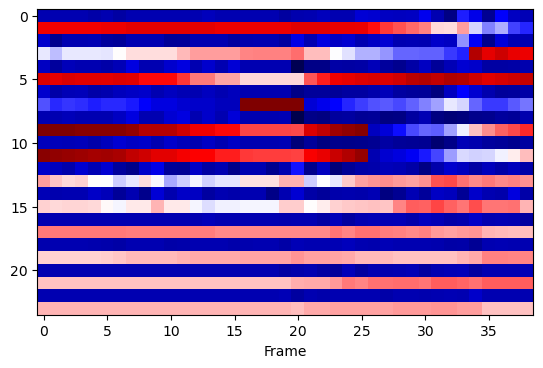

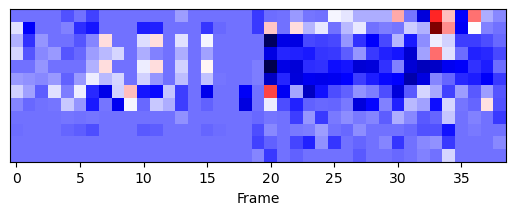

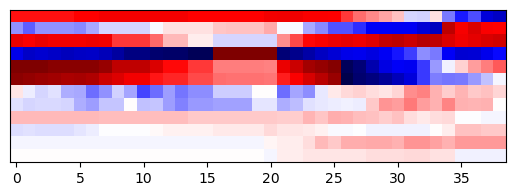

In [137]:
path = r'D:\JHMDB\processed_joints_new_v4'

annotations = glob.glob(f"{path}/golf/*.json")
for a in annotations:
    print(a)

    with open(a) as f:
        j = json.load(f)

    print(j[0][10])
    print(j[0][11])

    plt.figure()
    plt.xlabel("Frame")
    # plt.yticks(ticks=[])
    plt.imshow(np.asarray(j[0]), cmap='seismic')
    plt.show()

    plt.figure()
    plt.xlabel("Frame")
    plt.yticks(ticks=[])
    plt.imshow(np.asarray(j[0])[::2], cmap='seismic')
    plt.show()

    plt.figure()
    plt.yticks(ticks=[])
    plt.imshow(np.asarray(j[0])[1::2], cmap='seismic')
    plt.show()

    break